In [1]:
import os
os.chdir("..")

In [2]:
from lib import *
from keras.models import load_model
import csv


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
model = load_model('model-segmentation-3.2.h5', custom_objects={'mean_iou':mean_iou})





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 240, 240, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [5]:
BATCH_SIZE = 10 
# memory issues on 8 gig container
IMG_WIDTH = 240
IMG_HEIGHT = 240
IMG_CHANNELS = 3

TRAIN_PATH = 'data/train'
TRAIN_MASK_PATH = 'data/train_mask'

VALIDATE_PATH = 'data/valid'
VALIDATE_MASK_PATH = 'data/valid_mask'

TEST_PATH = 'data/test'

seed = 83

images = os.listdir(TRAIN_PATH)
val_images = os.listdir(VALIDATE_PATH)
test_images = os.listdir(TEST_PATH)

In [6]:
X_train, Y_train = get_xy(images, TRAIN_PATH, TRAIN_MASK_PATH)
X_validate, Y_validate = get_xy(val_images, VALIDATE_PATH, VALIDATE_MASK_PATH)
X_test, Y_test_placeholder = get_xy(test_images, TEST_PATH)

In [7]:
X_valid_320_240, Y_valid_predicted = predict_mask(model, X_validate)

In [8]:
from skimage.transform import resize

length_validate = len(Y_validate)
Y_validate_320_240 = np.zeros((length_validate, 320, 240), dtype=np.uint8)
for i in range(length_validate):
        Y_validate_320_240[i] = resize(Y_validate[i], (320, 240), mode='constant', 
                                              preserve_range=True).astype(np.uint8)[:,:,0]



## check avaerage dice metric

In [9]:
get_dice(Y_validate_320_240, Y_valid_predicted)

0.728527488457014

In [10]:
pred_valid_csv = []

for i in range(len(val_images)):
    img_id = val_images[i].split(".")[0]
    mask_ = Y_valid_predicted[0][:,:,None]
    
    pred_valid_csv.append({'id': img_id, 'rle_mask': encode_rle(mask_)})



## create result 1, csv 

In [11]:
csv_columns = ['id','rle_mask']
csv_file = "data/pred_valid_template.csv"
try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in pred_valid_csv:
            writer.writerow(data)
except IOError:
    print("I/O error") 


In [12]:
import pandas as pd
df = pd.read_csv(csv_file)
df.head()

,id,rle_mask
0,1409,1 1 3 1 5 1 7 1 9 1 11 1 13 1 15 1 17 1 19 1 2...
1,1353,1 1 3 1 5 1 7 1 9 1 11 1 13 1 15 1 17 1 19 1 2...
2,1435,1 1 3 1 5 1 7 1 9 1 11 1 13 1 15 1 17 1 19 1 2...
3,1421,1 1 3 1 5 1 7 1 9 1 11 1 13 1 15 1 17 1 19 1 2...
4,1347,1 1 3 1 5 1 7 1 9 1 11 1 13 1 15 1 17 1 19 1 2...


## check random masks

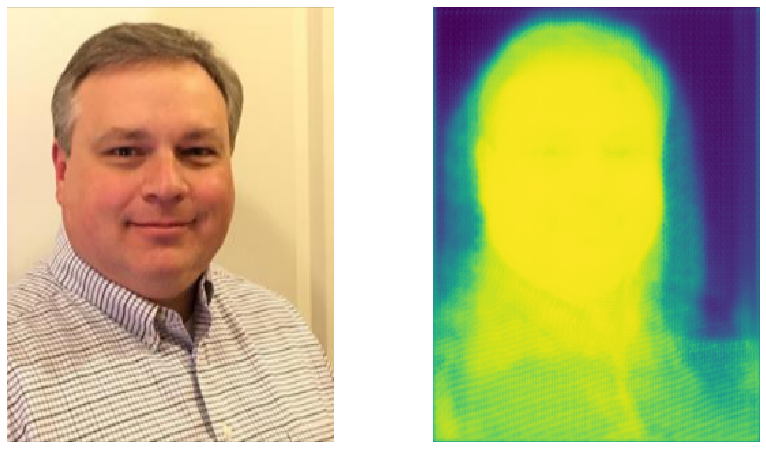

In [13]:
random_index = np.random.choice(X_validate.shape[0])
show_img_with_mask(X_valid_320_240[random_index], Y_valid_predicted[random_index])

In [14]:
X_test_320_240, Y_test_predicted = predict_mask(model, X_test)

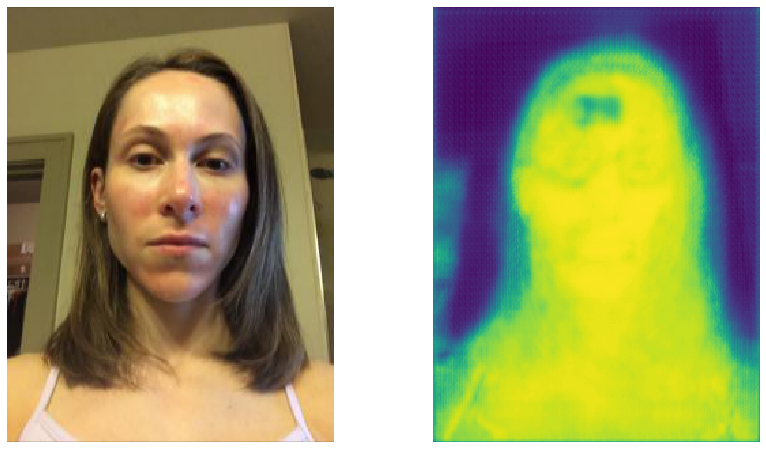

In [15]:
random_index = np.random.choice(X_test.shape[0])
show_img_with_mask(X_test_320_240[random_index], Y_test_predicted[random_index])

In [16]:
from skimage.io import imread, imshow
from matplotlib import pyplot as plt

plt.imsave('test.png', Y_test_predicted[random_index])


## write images

In [34]:
length_test = len(test_images)
for i in range(length_test):
    img_id = test_images[i].split(".")[0]    
    plt.imsave(f'data/test_mask/{img_id}.png', Y_test_predicted[i])    

In [18]:
from PIL import Image
from glob import glob

paths_to_imgs = sorted(glob("data/test/*"))
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/test_mask/*"))]


In [36]:
_ = get_html(paths_to_imgs, pred_masks, path_to_save="results/test")